In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('GP.csv')

In [4]:
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    847 non-null    object 
 1   Price   847 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.4+ KB


In [6]:
df.describe()

,Price
count,847.000000
mean,416.556906
std,453.665313
min,34.490000
25%,35.190000
50%,319.622000
75%,447.029000
max,1840.807000


Inference

The Average gold price in last 70 years is $416.56

Only 25% of the time, the gold price is above $447.07

Highest Gold price ever touched is $1840.81

In [8]:
df.shape

(847, 2)

In [9]:
print(f"Date range of gold prices available from - {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")

Date range of gold prices available from - 1950-01 to 2020-07


In [10]:
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df = df.set_index('Date')
df.head()

,Price
Date,
1950-01-01,34.73
1950-02-01,34.73
1950-03-01,34.73
1950-04-01,34.73
1950-05-01,34.73


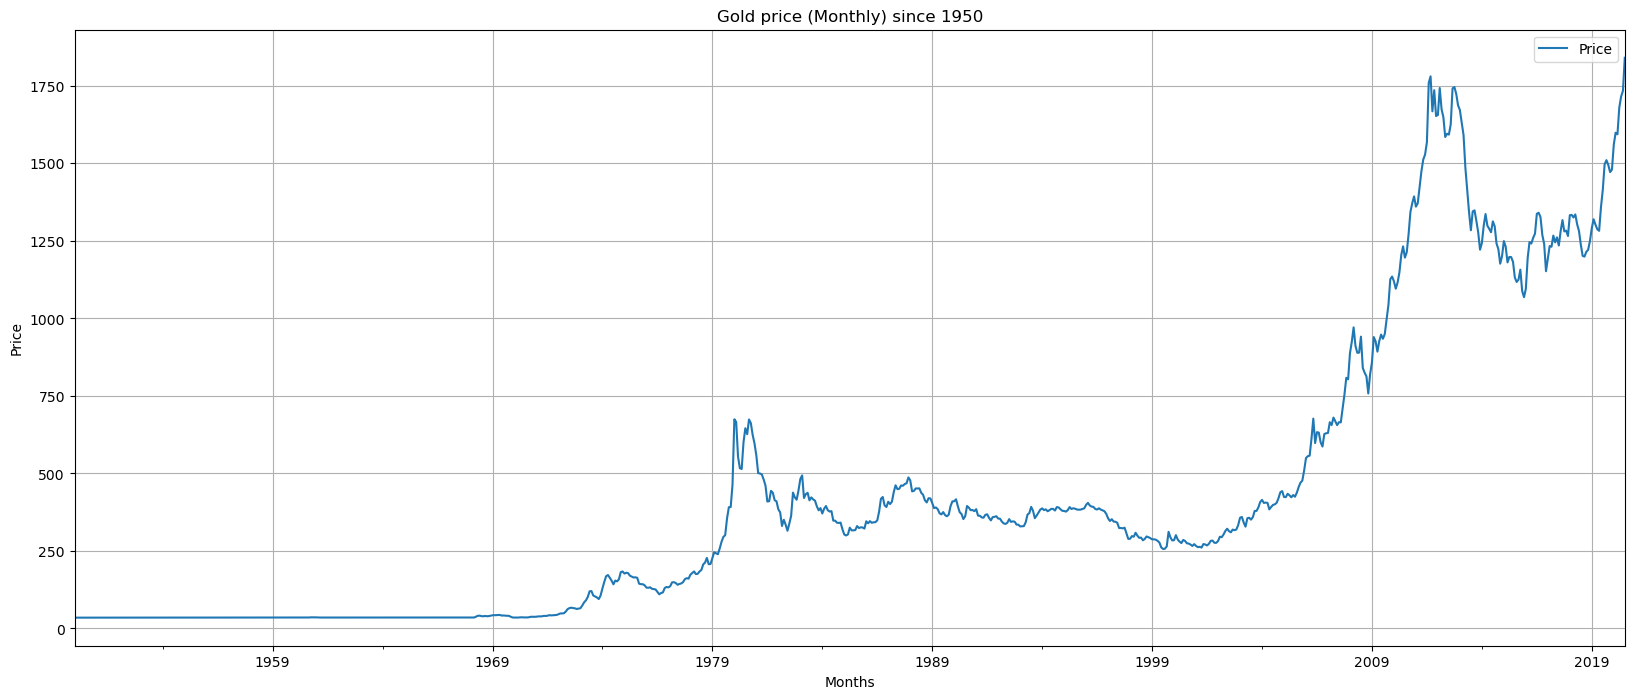

In [12]:
df.plot(figsize=(20,8))
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

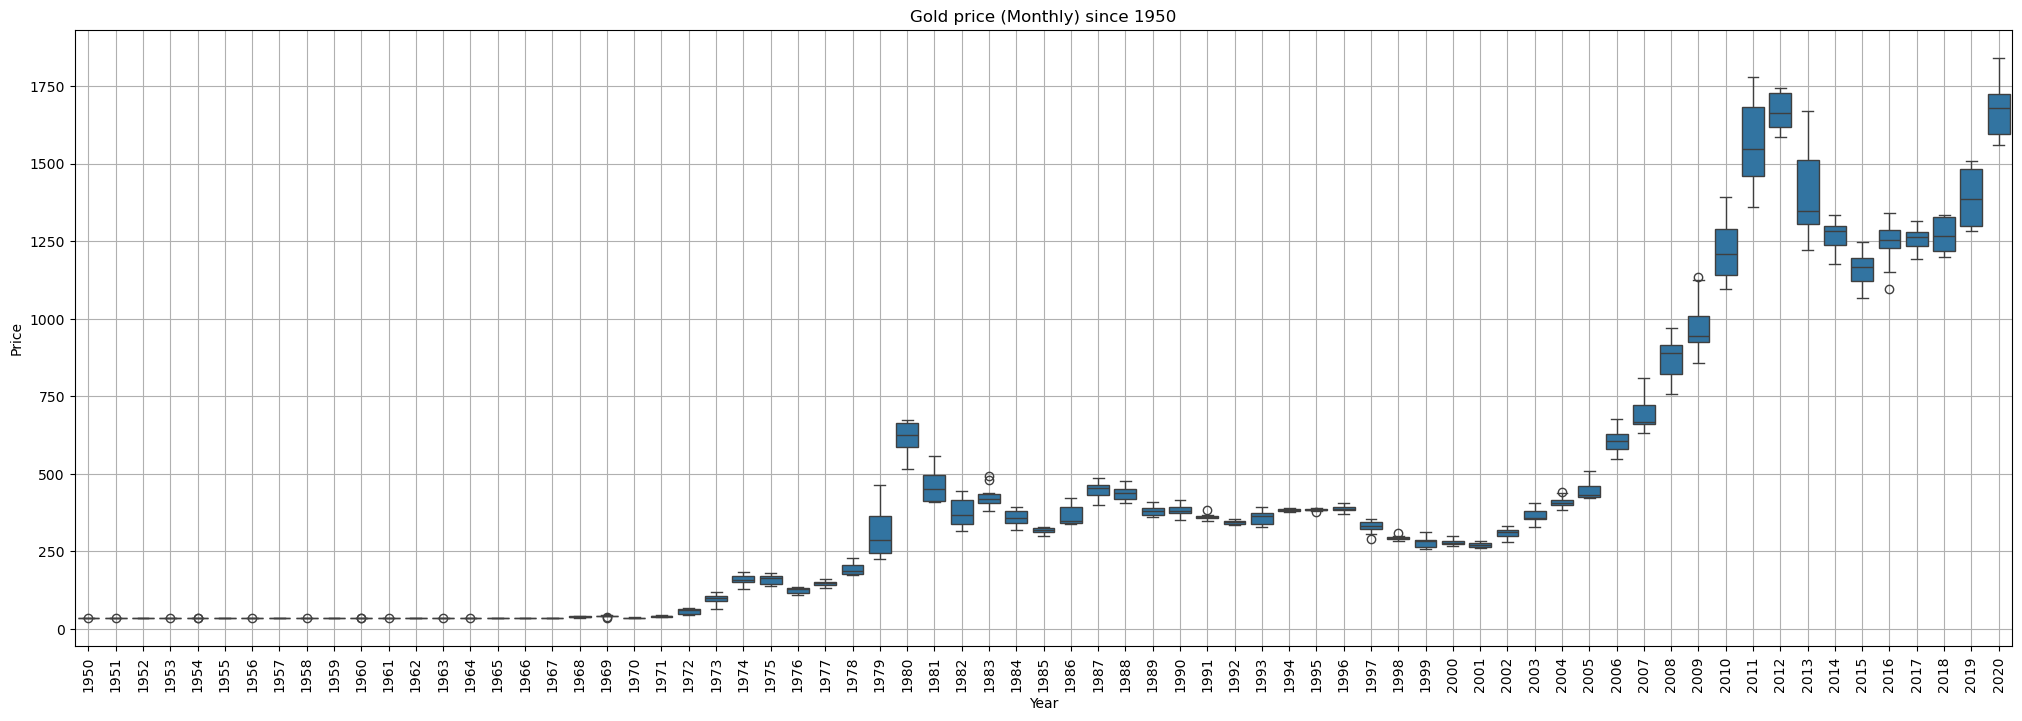

In [13]:
_, ax = plt.subplots(figsize=(25,8))
sns.boxplot(x = df.index.year,y = df.values[:,0],ax=ax)
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.xticks(rotation=90)
plt.grid();

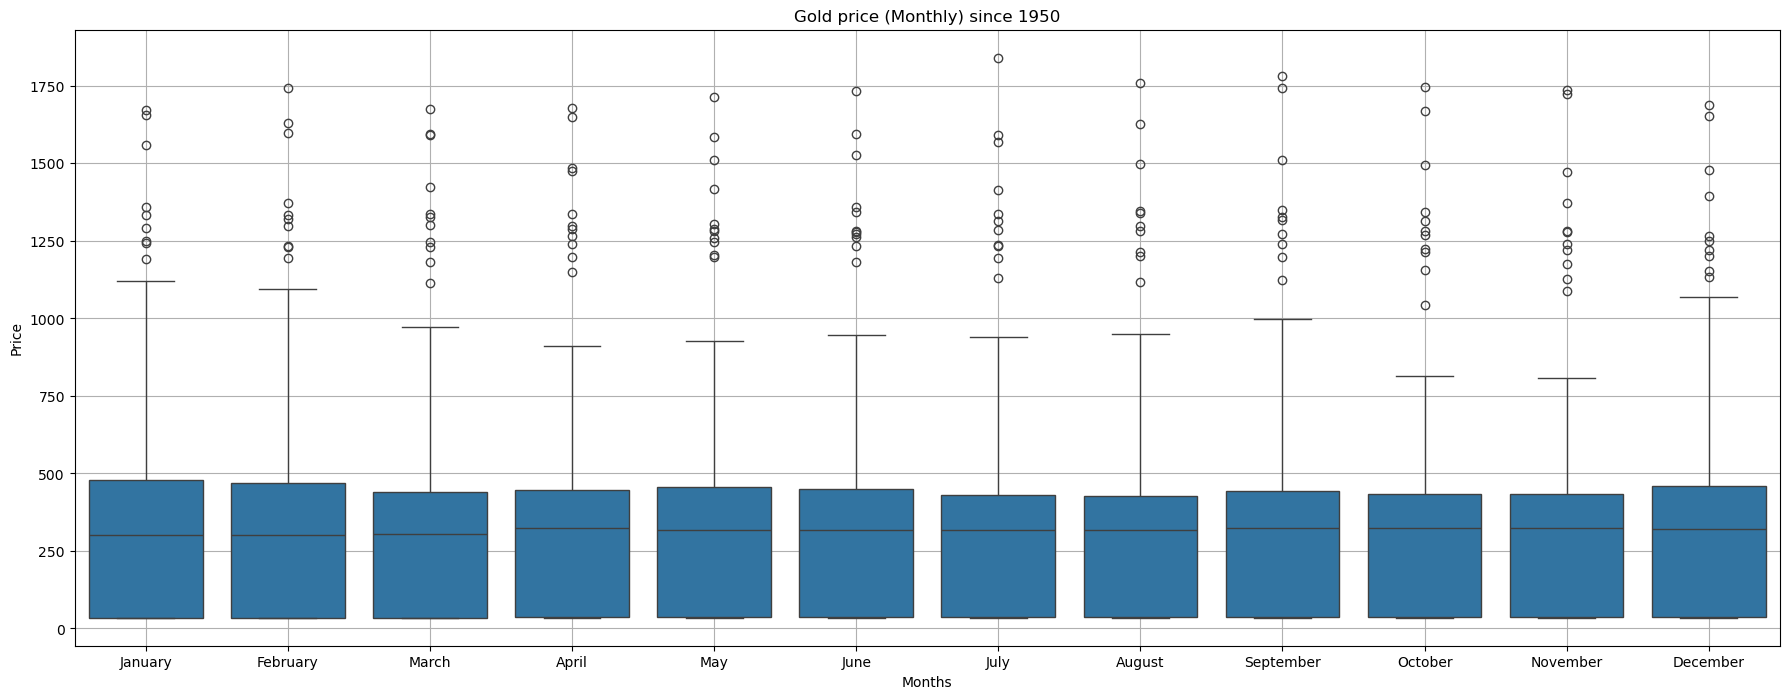

In [14]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df.index.month_name(),y = df.values[:,0],ax=ax)
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

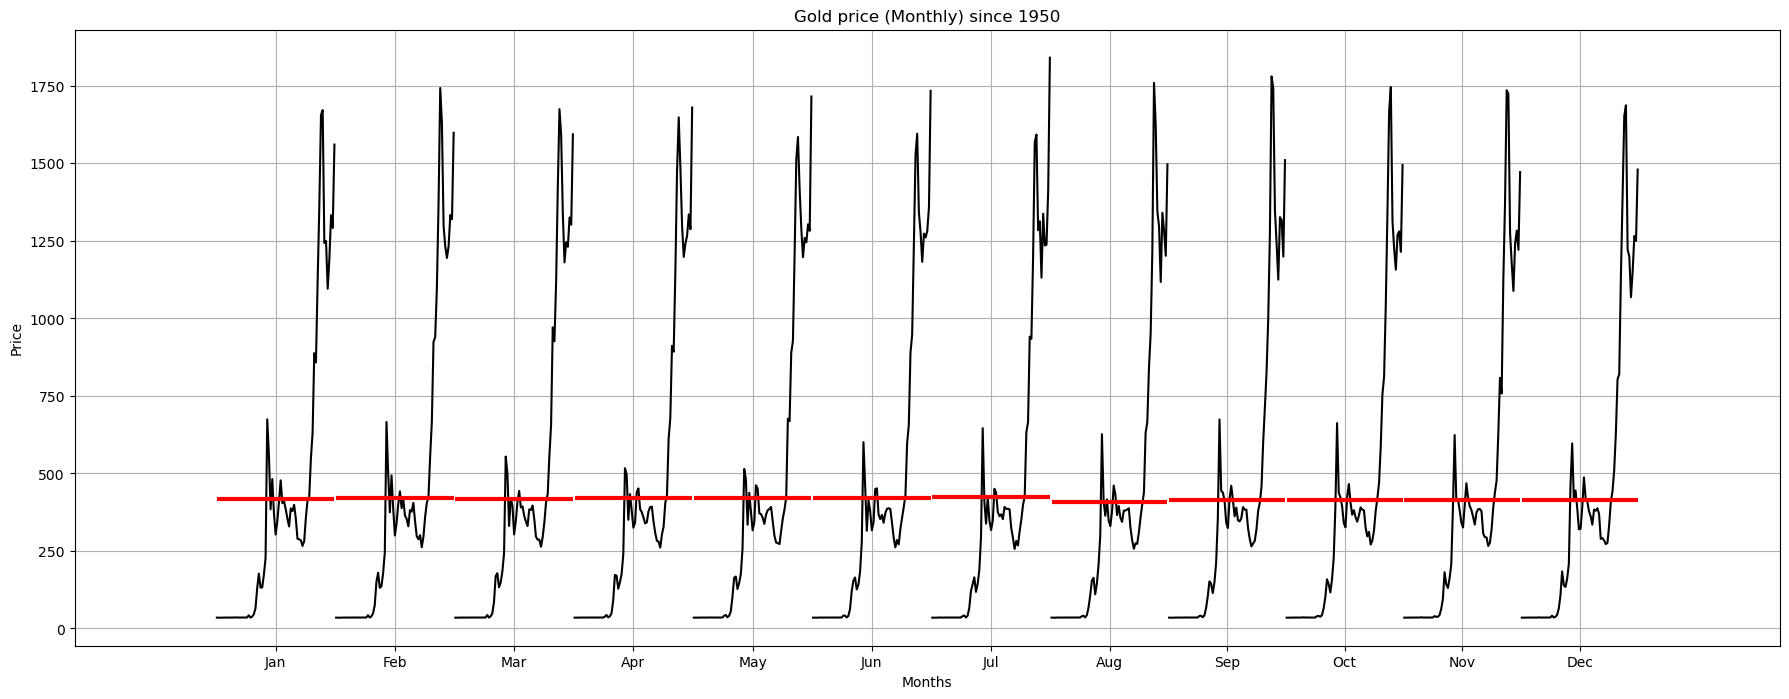

In [15]:
from statsmodels.graphics.tsaplots import month_plot

fig, ax = plt.subplots(figsize=(22,8))

month_plot(df,ylabel='Gold price',ax=ax)
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

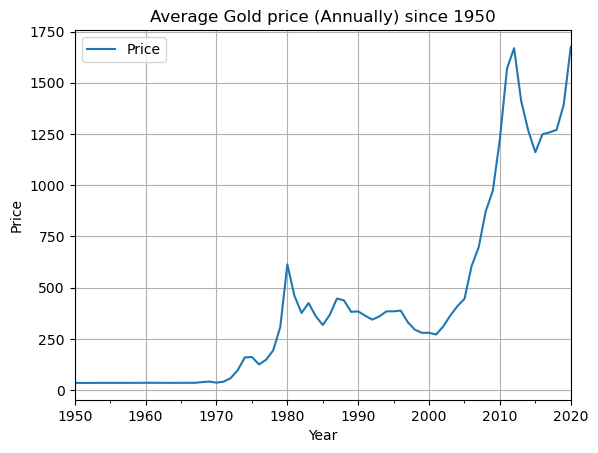

In [16]:
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot();
plt.title("Average Gold price (Annually) since 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.grid()

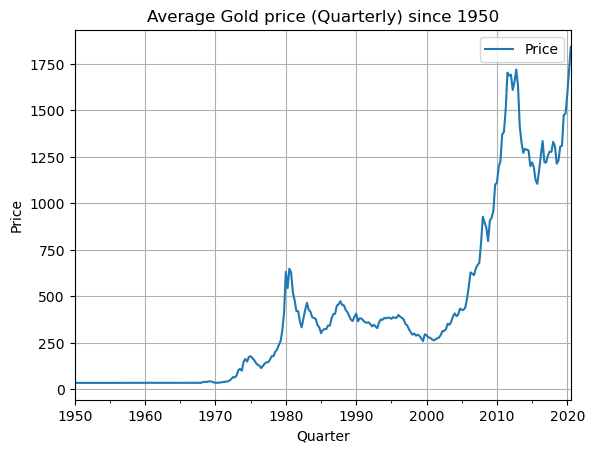

In [17]:
df_quarterly_sum = df.resample('Q').mean()
df_quarterly_sum.plot();
plt.title("Average Gold price (Quarterly) since 1950")
plt.xlabel("Quarter")
plt.ylabel("Price")
plt.grid()

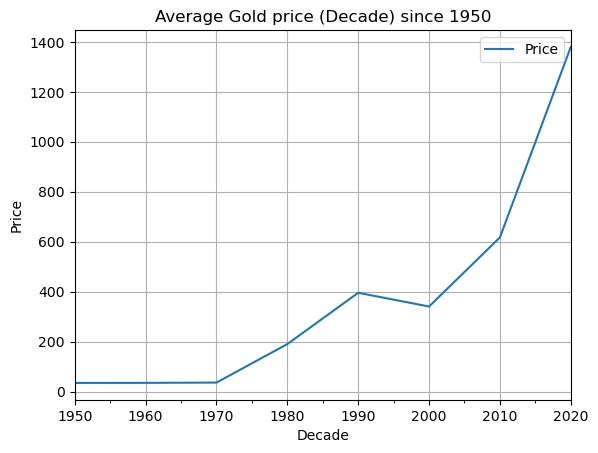

In [18]:
df_decade_sum = df.resample('10Y').mean()
df_decade_sum.plot();
plt.title("Average Gold price (Decade) since 1950")
plt.xlabel("Decade")
plt.ylabel("Price")
plt.grid()

In [19]:
train    =   df[df.index.year <= 2015] 
test     =   df[df.index.year > 2015]

In [20]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


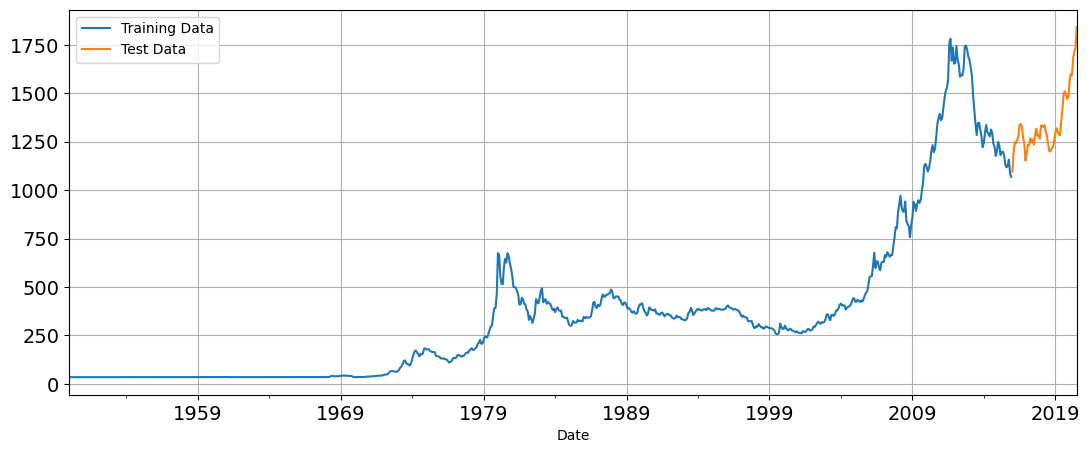

In [21]:
train['Price'].plot(figsize=(13,5), fontsize=14)
test['Price'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

# Linear Regression

In [23]:
train_time= [i+1 for i in range(len(train))]
test_time= [i+len(train)+1 for i in range(len(test))]
len(train_time),len(test_time)

(792, 55)

In [24]:
LR_train = train.copy()
LR_test = test.copy()

In [25]:
LR_train['time']=train_time
LR_test['time']=test_time

In [26]:
lr = LinearRegression()
lr.fit(LR_train[['time']],LR_train['Price'].values)

LinearRegression()

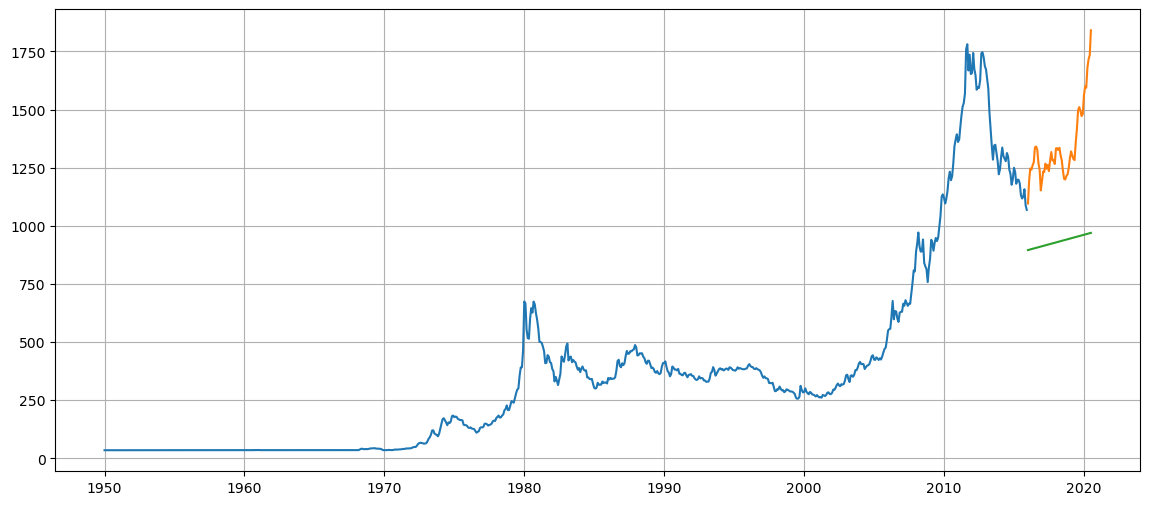

In [27]:
test_prediction_model1=lr.predict(LR_test[['time']])
LR_test['forecast']=test_prediction_model1

plt.figure(figsize=(14,6))
plt.plot(train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(LR_test['forecast'],label='reg on time_test data')
plt.grid()

In [28]:
def mape(actual, pred): return round((np.mean(abs(actual-pred)/actual))*100,2)

In [29]:
mape_model1_test=mape(test['Price'].values,test_prediction_model1)
print("MAPE is %3.3f"%(mape_model1_test),"%")

MAPE is 29.760 %


In [30]:
results = pd.DataFrame({'Test Mape (%)':[mape_model1_test]}, index=["RegressionOnTime"])
results

,Test Mape (%)
RegressionOnTime,29.76


# Naive Prediction

In [32]:
Naive_train=train.copy()
Naive_test=test.copy()

In [33]:
Naive_test['naive']=np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['naive'].head()

Date
2016-01-01    1068.317
2016-02-01    1068.317
2016-03-01    1068.317
2016-04-01    1068.317
2016-05-01    1068.317
Name: naive, dtype: float64

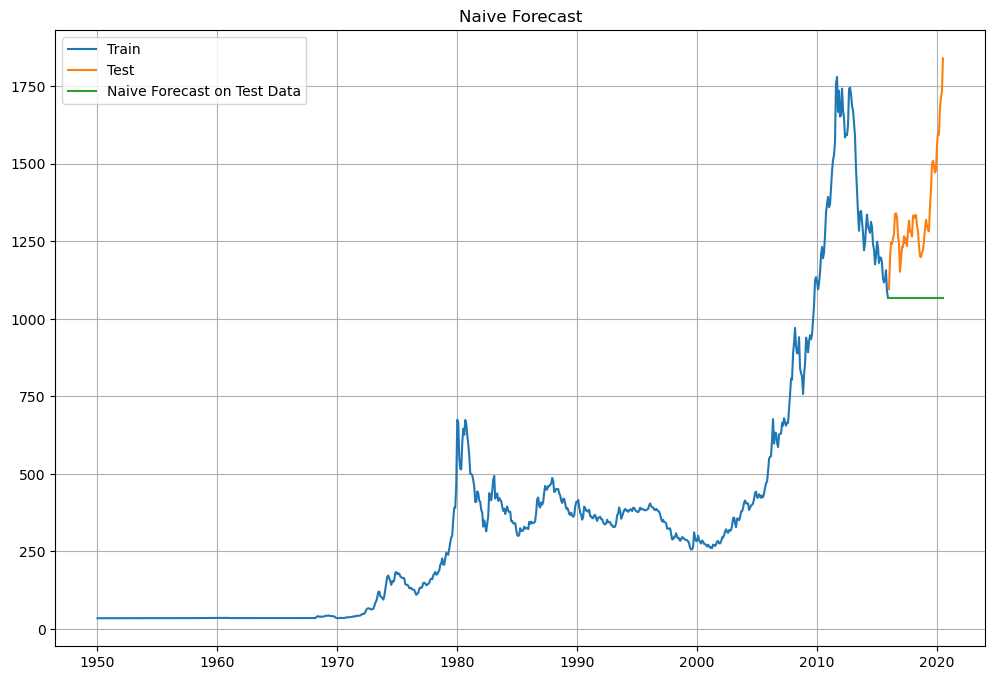

In [34]:
plt.figure(figsize=(12,8))
plt.plot(Naive_train['Price'],label='Train')
plt.plot(test['Price'],label='Test')
plt.plot(Naive_test['naive'],label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.grid()

In [35]:
mape_model2_test=mape(test['Price'].values,Naive_test['naive'].values)
print("For Naive forecast on the Test Data, MAPE is %3.3f"%(mape_model2_test),"%")

For Naive forecast on the Test Data, MAPE is 19.380 %


In [36]:
resultsDF_2=pd.DataFrame({'Test Mape (%)':[mape_model2_test]},index=['NaiveModel'])
results=pd.concat([results,resultsDF_2])
results

,Test Mape (%)
RegressionOnTime,29.76
NaiveModel,19.38


# Simple Average

In [38]:
SimpleAvg_train = train.copy()
SimpleAvg_test = test.copy()
SimpleAvg_test['mean_forecast'] = train['Price'].mean()
SimpleAvg_test.head()

,Price,mean_forecast
Date,,
2016-01-01,1095.655,352.371841
2016-02-01,1194.893,352.371841
2016-03-01,1246.312,352.371841
2016-04-01,1241.452,352.371841
2016-05-01,1259.755,352.371841


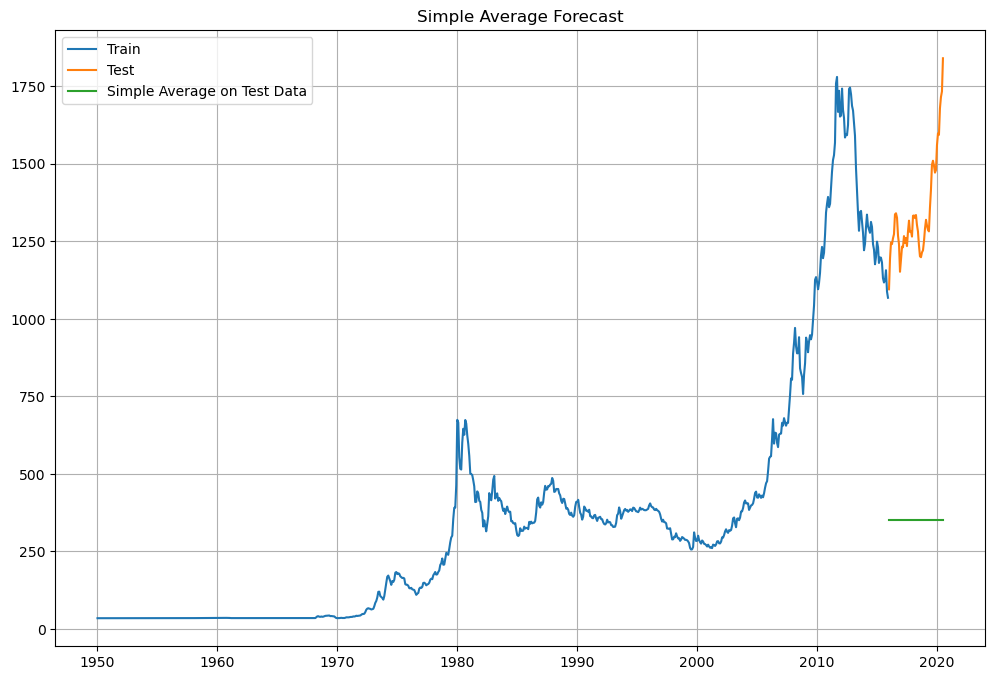

In [39]:
plt.figure(figsize=(12,8))
plt.plot(SimpleAvg_train['Price'], label='Train')
plt.plot(SimpleAvg_test['Price'], label='Test')
plt.plot(SimpleAvg_test['mean_forecast'], label='Simple Average on Test Data')
plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.grid();

In [40]:
mape_model3_test = mape(test['Price'].values,SimpleAvg_test['mean_forecast'].values)
print("For Simple Average forecast on the Test Data,  MAPE is %3.3f" %(mape_model3_test),"%")

For Simple Average forecast on the Test Data,  MAPE is 73.410 %


In [41]:
resultsDf_3 = pd.DataFrame({'Test Mape (%)': [mape_model3_test]},index=['SimpleAverageModel'])

results = pd.concat([results, resultsDf_3])
results

,Test Mape (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41


# Moving Average

In [43]:
Mvg_Avg = df.copy()
Mvg_Avg['Trailing_2'] = Mvg_Avg['Price'].rolling(2).mean()
Mvg_Avg['Trailing_3'] = Mvg_Avg['Price'].rolling(3).mean()
Mvg_Avg['Trailing_5'] = Mvg_Avg['Price'].rolling(5).mean()
Mvg_Avg['Trailing_7'] = Mvg_Avg['Price'].rolling(7).mean()
Mvg_Avg.head()

,Price,Trailing_2,Trailing_3,Trailing_5,Trailing_7
Date,,,,,
1950-01-01,34.73,NaN,NaN,NaN,NaN
1950-02-01,34.73,34.73,NaN,NaN,NaN
1950-03-01,34.73,34.73,34.73,NaN,NaN
1950-04-01,34.73,34.73,34.73,NaN,NaN
1950-05-01,34.73,34.73,34.73,34.73,NaN


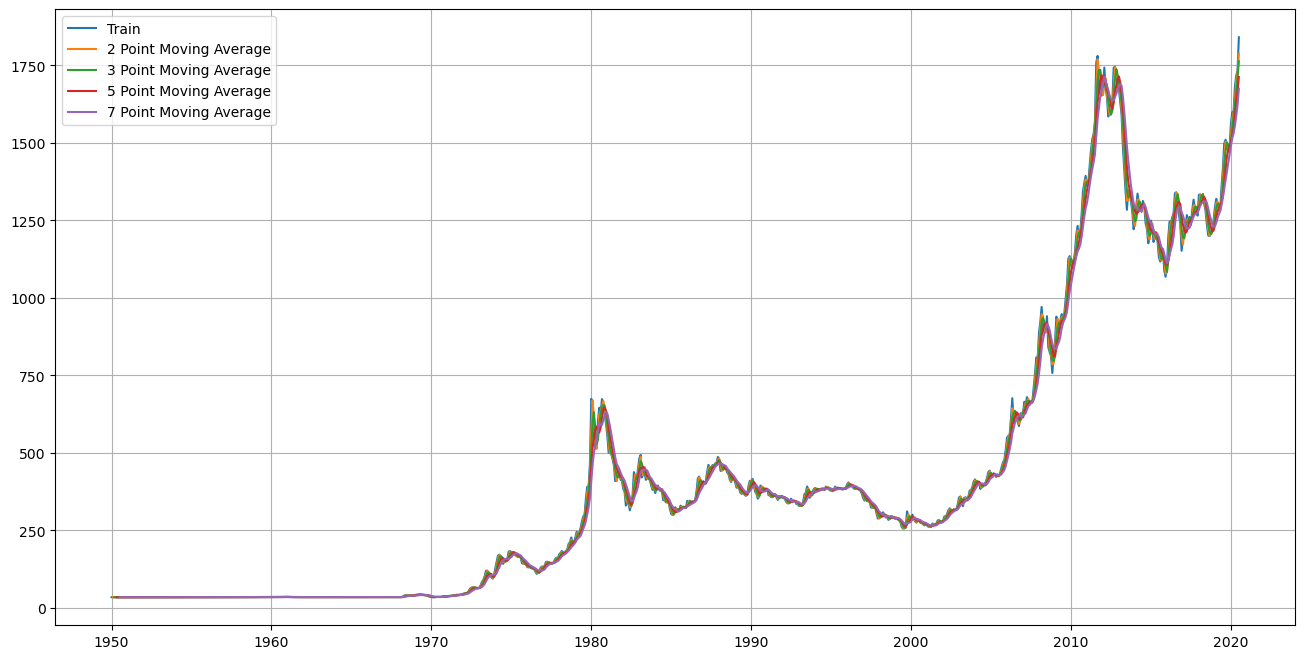

In [44]:
plt.figure(figsize=(16,8))
plt.plot(Mvg_Avg['Price'], label='Train')
plt.plot(Mvg_Avg['Trailing_2'],label='2 Point Moving Average')
plt.plot(Mvg_Avg['Trailing_3'],label='3 Point Moving Average')
plt.plot(Mvg_Avg['Trailing_5'],label = '5 Point Moving Average')
plt.plot(Mvg_Avg['Trailing_7'],label = '7 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

In [45]:
trailing_Mvg_Avg_train=Mvg_Avg[Mvg_Avg.index.year <= 2015] 
trailing_Mvg_Avg_test=Mvg_Avg[Mvg_Avg.index.year > 2015]

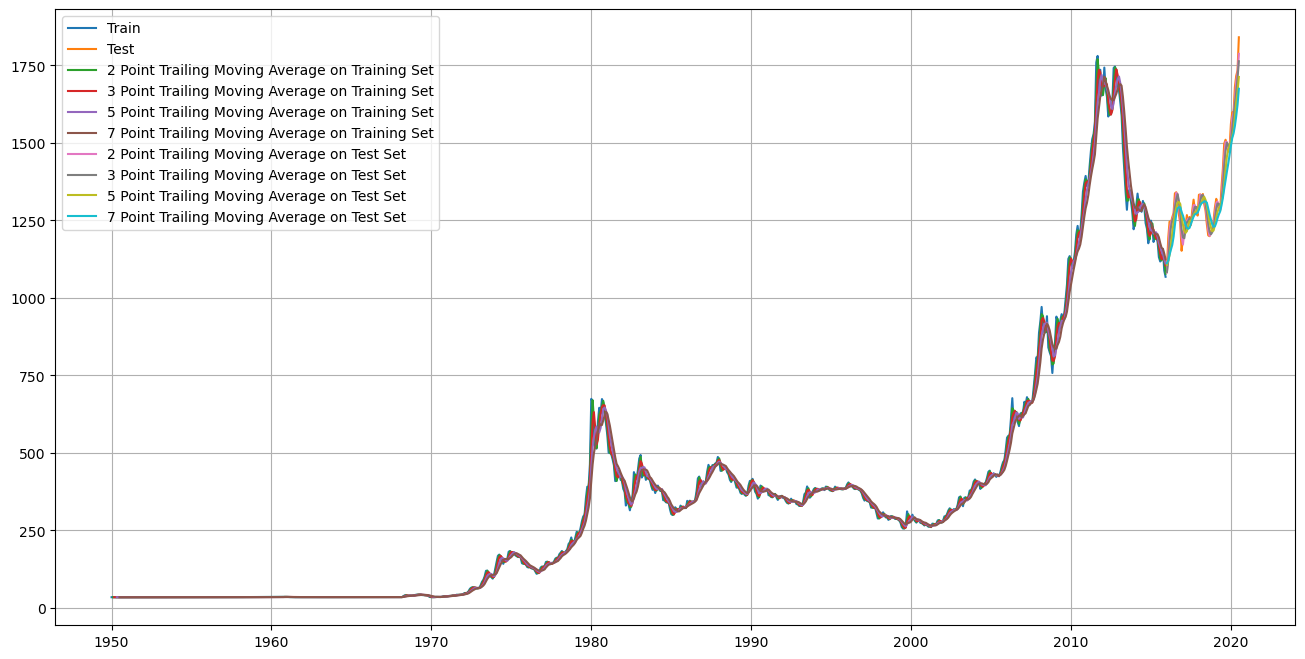

In [46]:
plt.figure(figsize=(16,8))
plt.plot(trailing_Mvg_Avg_train['Price'], label='Train')
plt.plot(trailing_Mvg_Avg_test['Price'], label='Test')

plt.plot(trailing_Mvg_Avg_train['Trailing_2'],label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_Mvg_Avg_train['Trailing_3'],label='3 Point Trailing Moving Average on Training Set')
plt.plot(trailing_Mvg_Avg_train['Trailing_5'],label = '5 Point Trailing Moving Average on Training Set')
plt.plot(trailing_Mvg_Avg_train['Trailing_7'],label = '7 Point Trailing Moving Average on Training Set')

plt.plot(trailing_Mvg_Avg_test['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_Mvg_Avg_test['Trailing_3'], label='3 Point Trailing Moving Average on Test Set')
plt.plot(trailing_Mvg_Avg_test['Trailing_5'],label = '5 Point Trailing Moving Average on Test Set')
plt.plot(trailing_Mvg_Avg_test['Trailing_7'],label = '7 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.grid();

In [47]:
mape_model4_test_2 = mape(test['Price'].values,trailing_Mvg_Avg_test['Trailing_2'].values)
print("For 2 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f" %(mape_model4_test_2),"%")

## Test Data - MAPE  --> 3 point Trailing MA

mape_model4_test_3 = mape(test['Price'].values,trailing_Mvg_Avg_test['Trailing_3'].values)
print("For 3 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f" %(mape_model4_test_3),"%")

## Test Data - MAPE --> 5 point Trailing MA

mape_model4_test_5 = mape(test['Price'].values,trailing_Mvg_Avg_test['Trailing_5'].values)
print("For 5 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f" %(mape_model4_test_5),"%")

## Test Data - MAPE  --> 7 point Trailing MA

mape_model4_test_7 = mape(test['Price'].values,trailing_Mvg_Avg_test['Trailing_7'].values)
print("For 7 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f " %(mape_model4_test_7),"%")

For 2 point Moving Average Model forecast on the Training Data,  MAPE is 1.230 %
For 3 point Moving Average Model forecast on the Training Data,  MAPE is 2.050 %
For 5 point Moving Average Model forecast on the Training Data,  MAPE is 3.330 %
For 7 point Moving Average Model forecast on the Training Data,  MAPE is 4.180  %


In [48]:
resultsDf_4 = pd.DataFrame({'Test Mape (%)': [mape_model4_test_2,mape_model4_test_3
                                          ,mape_model4_test_5,mape_model4_test_7]}
                           ,index=['2pointTrailingMovingAverage','3pointTrailingMovingAverage'
                                   ,'5pointTrailingMovingAverage','7pointTrailingMovingAverage'])

results = pd.concat([results, resultsDf_4])
results

,Test Mape (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18


# Simple Exponential Smoothing

In [50]:
SES_train = train.copy()
SES_test = test.copy()

In [51]:
model_SES = SimpleExpSmoothing(SES_train['Price'])
model_SES_autofit = model_SES.fit(optimized=True)

In [52]:
model_SES_autofit.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 34.73,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [53]:
SES_test['predict'] = model_SES_autofit.forecast(steps=len(test))
SES_test.head()

,Price,predict
Date,,
2016-01-01,1095.655,1068.419069
2016-02-01,1194.893,1068.419069
2016-03-01,1246.312,1068.419069
2016-04-01,1241.452,1068.419069
2016-05-01,1259.755,1068.419069


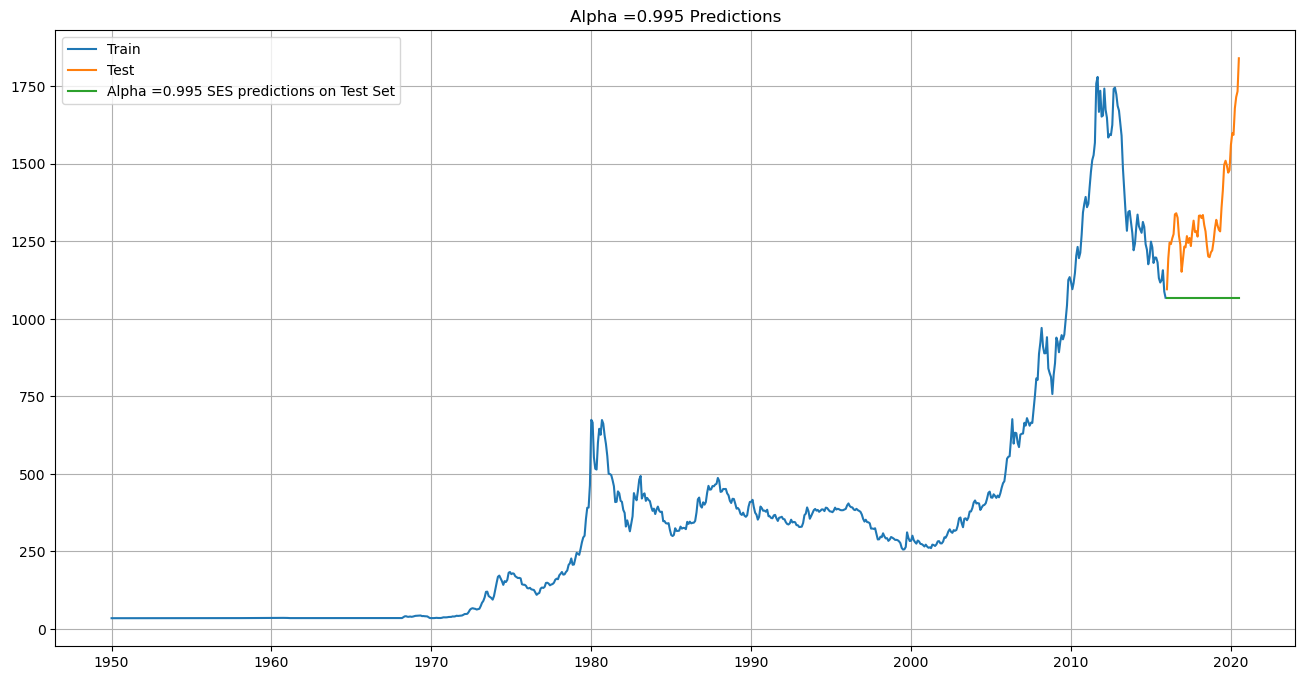

In [54]:
plt.figure(figsize=(16,8))
plt.plot(SES_train['Price'], label='Train')
plt.plot(SES_test['Price'], label='Test')

plt.plot(SES_test['predict'], label='Alpha =0.995 SES predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha =0.995 Predictions');

In [55]:
mape_model5_test_1 = mape(SES_test['Price'].values,SES_test['predict'].values)
print("For Alpha =0.995 SES Model forecast on the Test Data, MAPE is %3.3f" %(mape_model5_test_1),"%")

For Alpha =0.995 SES Model forecast on the Test Data, MAPE is 19.380 %


In [56]:
resultsDf_5 = pd.DataFrame({'Test Mape (%)': [mape_model5_test_1]},index=['Alpha=0.995,SimpleExponentialSmoothing'])

results = pd.concat([results, resultsDf_5])
results

,Test Mape (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18
"Alpha=0.995,SimpleExponentialSmoothing",19.38


In [57]:
resultsDf_6 = pd.DataFrame({'Alpha Values':[], 'Train MAPE':[], 'Test MAPE': []})

# Simulating your loop
for i in np.arange(0.3, 1, 0.1):
    model_SES_alpha_i = model_SES.fit(smoothing_level=i, optimized=False, use_brute=True)
    SES_train[f'predict_{i}'] = model_SES_alpha_i.fittedvalues
    SES_test[f'predict_{i}'] = model_SES_alpha_i.forecast(steps=55)
    
    # Assuming the mape function is defined and works correctly
    mape_model5_train_i = mape(SES_train['Price'].values, SES_train[f'predict_{i}'].values)
    mape_model5_test_i = mape(SES_test['Price'].values, SES_test[f'predict_{i}'].values)
    
    # Creating a temporary DataFrame for each iteration
    temp_df = pd.DataFrame({'Alpha Values': [i], 'Train MAPE': [mape_model5_train_i], 'Test MAPE': [mape_model5_test_i]})
    
    # Concatenating the temporary DataFrame with the results DataFrame
    resultsDf_6 = pd.concat([resultsDf_6, temp_df], ignore_index=True)

# Displaying the final DataFrame
print(resultsDf_6)

   Alpha Values  Train MAPE  Test MAPE
0           0.3        4.02      16.03
1           0.4        3.45      16.92
2           0.5        3.11      17.57
3           0.6        2.87      18.09
4           0.7        2.71      18.53
5           0.8        2.58      18.89
6           0.9        2.47      19.18


In [58]:
resultsDf_6.sort_values(by=['Test MAPE'],ascending=True)

,Alpha Values,Train MAPE,Test MAPE
0,0.3,4.02,16.03
1,0.4,3.45,16.92
2,0.5,3.11,17.57
3,0.6,2.87,18.09
4,0.7,2.71,18.53
5,0.8,2.58,18.89
6,0.9,2.47,19.18


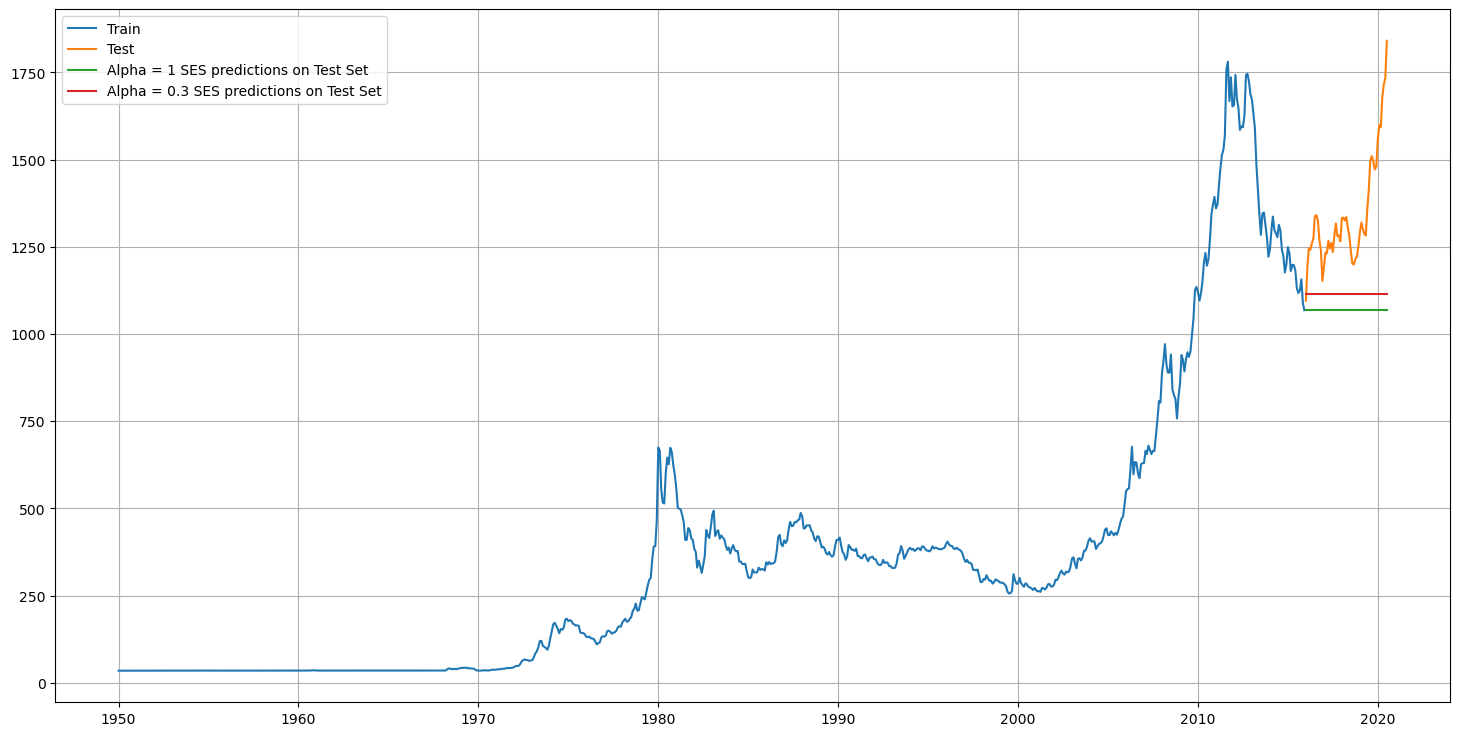

In [59]:
plt.figure(figsize=(18,9))

# Plotting train and test prices
plt.plot(SES_train['Price'], label='Train')
plt.plot(SES_test['Price'], label='Test')

# Plotting the SES predictions with different alpha values
plt.plot(SES_test['predict'], label='Alpha = 1 SES predictions on Test Set')  # Assuming you stored alpha=1 prediction as 'predict_1'
plt.plot(SES_test['predict_0.3'], label='Alpha = 0.3 SES predictions on Test Set')  # Assuming you stored alpha=0.3 prediction as 'predict_0.3'

# Adding legend and grid
plt.legend(loc='best')
plt.grid()

# Display the plot
plt.show()

In [60]:
resultsDf_6_1 = pd.DataFrame({'Test Mape (%)': [resultsDf_6.sort_values(by=['Test MAPE'],ascending=True).values[0][2]]}
                           ,index=['Alpha=0.3,SimpleExponentialSmoothing'])

results = pd.concat([results, resultsDf_6_1])
results

,Test Mape (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18
"Alpha=0.995,SimpleExponentialSmoothing",19.38
"Alpha=0.3,SimpleExponentialSmoothing",16.03


# Double Exponential Smoothing

In [62]:
DES_train = train.copy()
DES_test = test.copy()

In [63]:
model_DES = Holt(DES_train['Price'])

In [64]:
resultsDf_7 = pd.DataFrame({'Alpha Values':[], 'Beta Values':[], 'Train MAPE':[], 'Test MAPE': []})

# Loop through alpha and beta values
for i in np.arange(0.3, 1.1, 0.1):
    for j in np.arange(0.3, 1.1, 0.1):
        model_DES_alpha_i_j = model_DES.fit(smoothing_level=i, smoothing_trend=j, optimized=False, use_brute=True)
        
        # Store predictions in columns with combined alpha and beta in the name
        DES_train[f'predict_{i}_{j}'] = model_DES_alpha_i_j.fittedvalues
        DES_test[f'predict_{i}_{j}'] = model_DES_alpha_i_j.forecast(steps=55)
        
        # Calculate MAPE
        mape_model6_train = mape(DES_train['Price'].values, DES_train[f'predict_{i}_{j}'].values)
        mape_model6_test = mape(DES_test['Price'].values, DES_test[f'predict_{i}_{j}'].values)
        
        # Append results to the DataFrame
        resultsDf_7 = pd.concat([resultsDf_7, pd.DataFrame({'Alpha Values': [i], 'Beta Values': [j], 'Train MAPE': [mape_model6_train], 'Test MAPE': [mape_model6_test]})], ignore_index=True)

# Display the final DataFrame
print(resultsDf_7)


    Alpha Values  Beta Values  Train MAPE  Test MAPE
0            0.3          0.3        3.60      47.89
1            0.3          0.4        3.61      48.59
2            0.3          0.5        3.64      52.17
3            0.3          0.6        3.70      56.41
4            0.3          0.7        3.78      57.62
..           ...          ...         ...        ...
59           1.0          0.6        2.72      71.38
60           1.0          0.7        2.79      72.91
61           1.0          0.8        2.87      71.94
62           1.0          0.9        2.94      67.80
63           1.0          1.0        3.03      59.95

[64 rows x 4 columns]


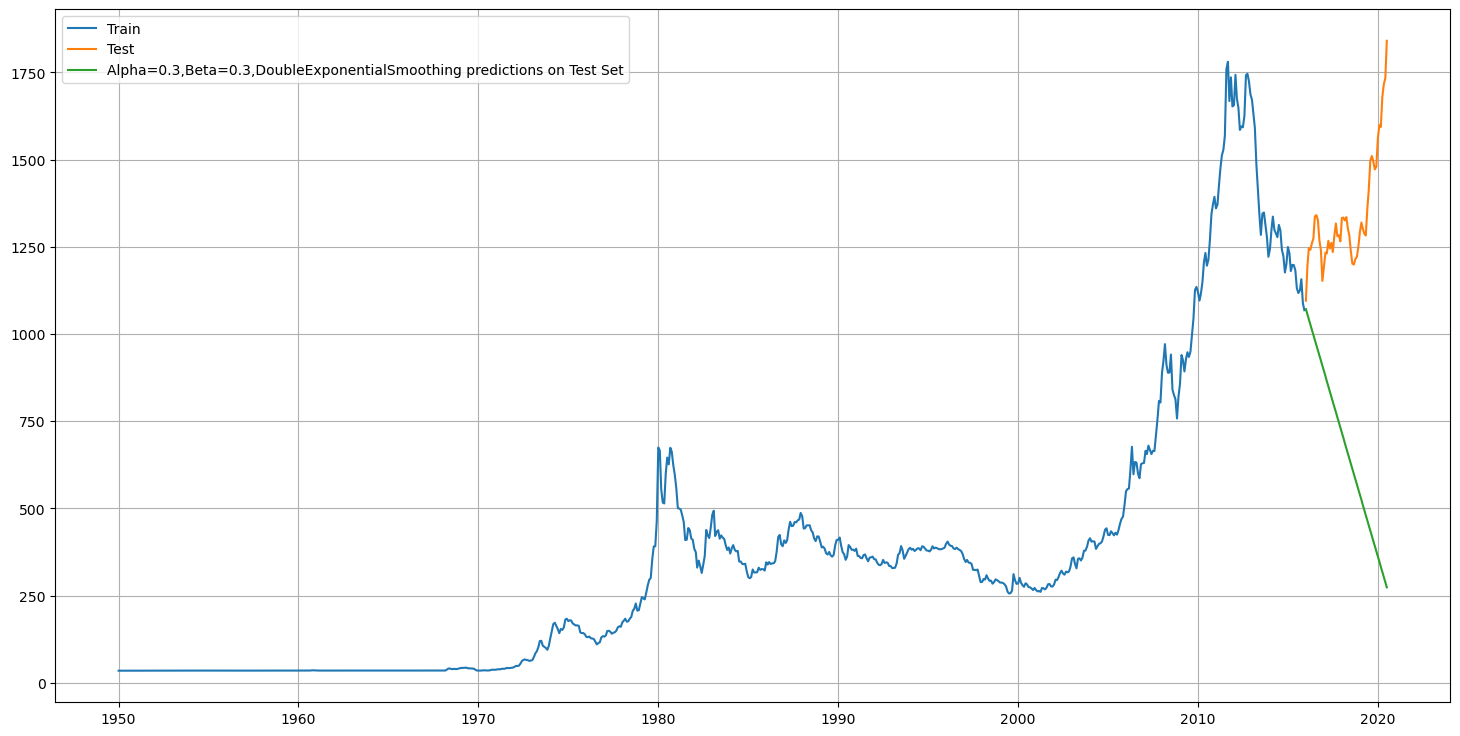

In [65]:
plt.figure(figsize=(18,9))
plt.plot(DES_train['Price'], label='Train')
plt.plot(DES_test['Price'], label='Test')

plt.plot(DES_test['predict_0.3_0.3'], label='Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [66]:
resultsDf_7_1 = pd.DataFrame({'Test Mape (%)': [resultsDf_7.sort_values(by=['Test MAPE']).values[0][3]]}
                           ,index=['Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing'])

results = pd.concat([results, resultsDf_7_1])
results

,Test Mape (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18
"Alpha=0.995,SimpleExponentialSmoothing",19.38
"Alpha=0.3,SimpleExponentialSmoothing",16.03
"Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing",47.89


# Exponential Smoothing

In [68]:
final_model=ExponentialSmoothing(df,
                                trend='additive',
                                seasonal='additive').fit(smoothing_level=0.4,
                                                         smoothing_trend=0.3,
                                                         smoothing_seasonal=0.6)

In [69]:
Mape_final_model=mape(df['Price'].values,final_model.fittedvalues)
print('MAPE:',Mape_final_model)

MAPE: 17.24


In [70]:
prediction=final_model.forecast(steps=len(test))

In [71]:
pred_df=pd.DataFrame({'lower_CI':prediction-1.96*np.std(final_model.resid,ddof=1),
                     'prediction':prediction,
                     'upper_CI':prediction+1.96*np.std(final_model.resid,ddof=1)})
pred_df.head()

,lower_CI,prediction,upper_CI
2020-08-01,1684.716748,1792.867721,1901.018694
2020-09-01,1615.298179,1723.449152,1831.600125
2020-10-01,1538.554867,1646.705839,1754.856812
2020-11-01,1476.740491,1584.891463,1693.042436
2020-12-01,1459.304892,1567.455865,1675.606837


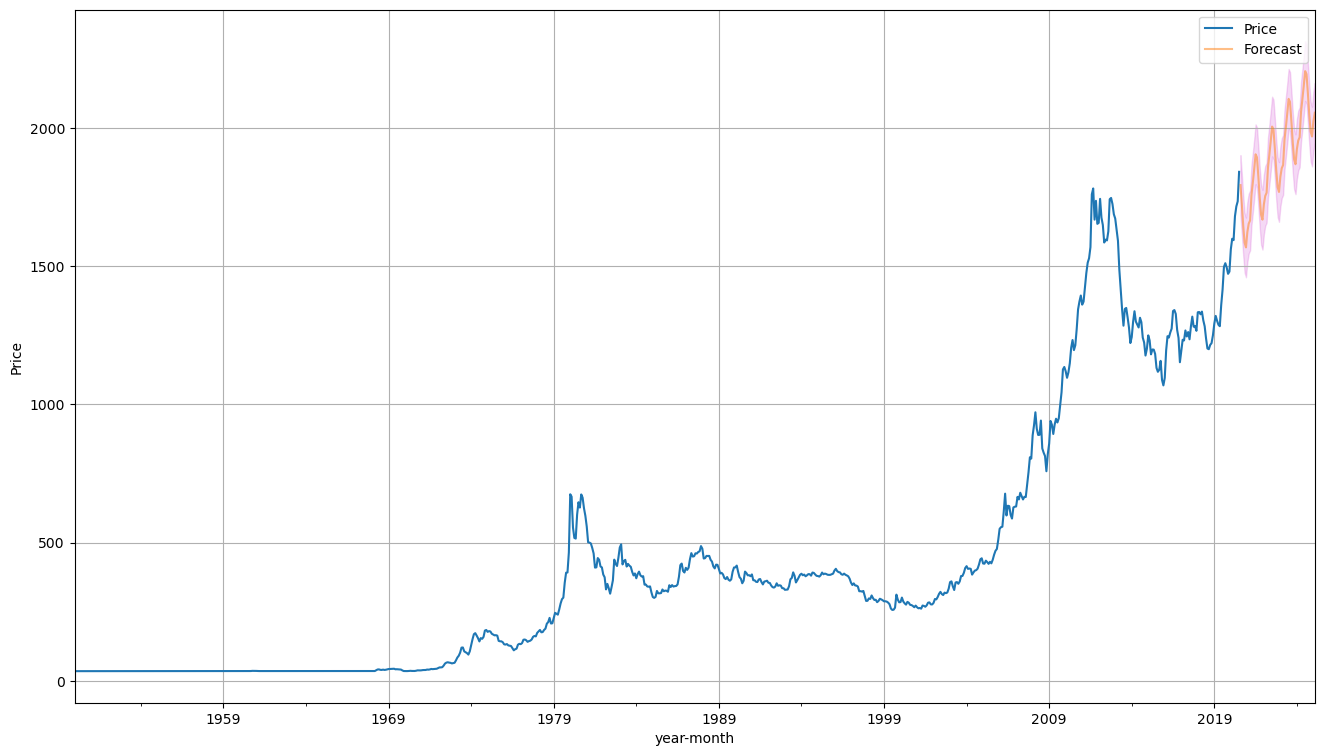

In [72]:
axis=df.plot(label='Actual',figsize=(16,9))
pred_df['prediction'].plot(ax=axis,label='Forecast',alpha=0.5)
axis.fill_between(pred_df.index,pred_df['lower_CI'],pred_df['upper_CI'],color='m',alpha=0.15)
axis.set_xlabel('year-month')
axis.set_ylabel('Price')
plt.legend(loc='best')
plt.grid()
plt.show()